# **Unstructured Data in Empirical Economics**

*Coding session 3: Introduction to Large Language Models*

<br>

[Yabra Muvdi](https://yabramuvdi.github.io/) (ETH Zürich)

<br>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github//unstructured-data/course-unstructured-data-23/blob/main/notebooks/3_coding_session.ipynb)

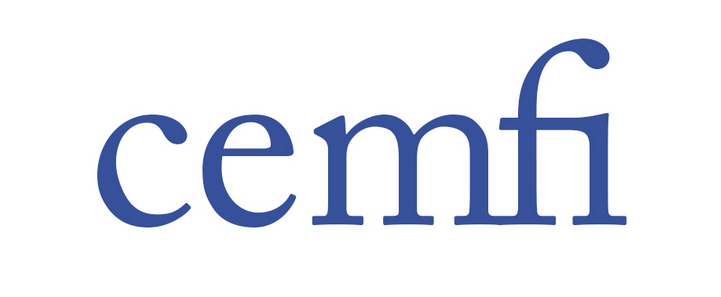

This notebook illustrates how to use a large language model (LLM) in the context of a particular classification task. We will use the ```transformers``` library to load and train LLMs. Concretely, we will use the text from firm's 10-K reports in order to predict their economic sector. Once we have a trained a model to accurately do this, we will show how to make predictions for out-of-sample text. We will also show how to create a sectorial membership probability for any firm by using the trained model.

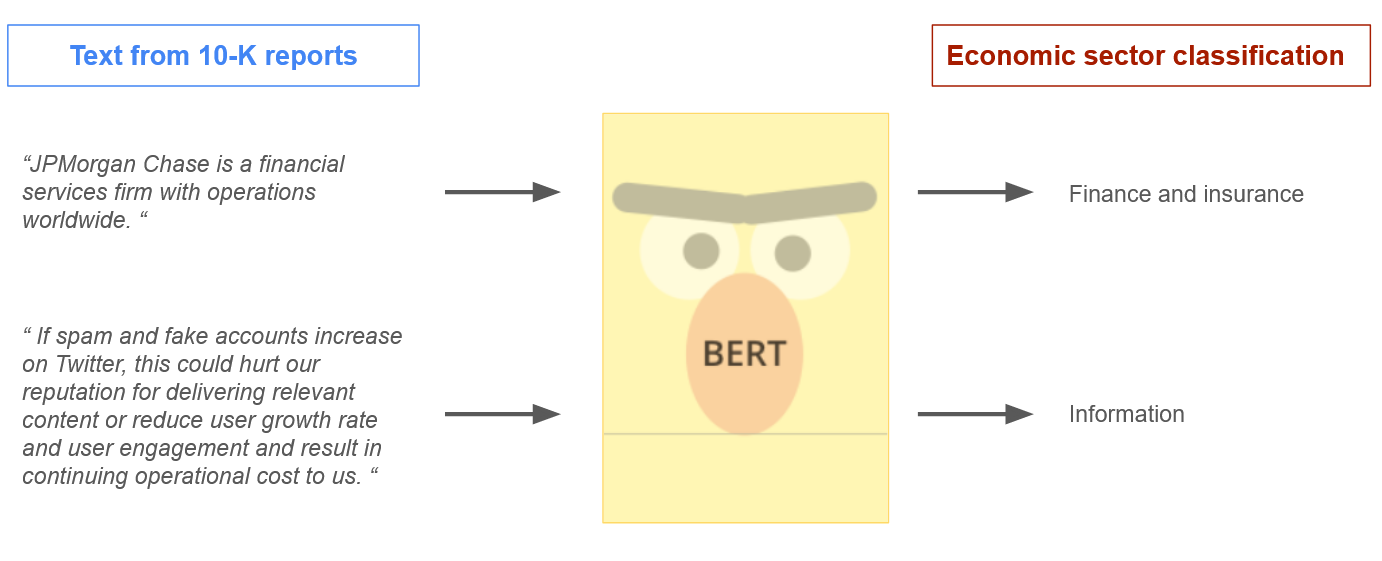

# 0. Setup

In [ ]:
# Instructions for Colab: CHANGE RUNTIME TYPE to GPU

In [2]:
%%capture

# install required libraries
!pip3 install transformers                  # HuggingFace library for interacting with BERT (and multiple other models)
!pip3 install accelerate                    # fast optimization with transformers
!pip3 install datasets                      # HuggingFace library to process dataframes
!pip3 install ipywidgets

In [3]:
# (COLAB) you might need to restart RUNTIME after installing packages!

In [4]:
#### import libraries

# basic libraries
import pandas as pd
import numpy as np
import torch
import random
from IPython.core.display import HTML
from scipy.special import softmax

# libraries for plots and figures
import seaborn as sns
import matplotlib.pyplot as plt

# HuggingFace relevant classes
from transformers import AutoModel, BertModel, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, pipeline, TrainingArguments, Trainer, utils
from transformers import TextClassificationPipeline
from transformers.pipelines.base import KeyDataset
from datasets import load_dataset, load_metric, Dataset, DatasetDict

# scikit-learn relevant classes
from sklearn.model_selection import cross_val_score, train_test_split

# test GPU
print(f"GPU: {torch.cuda.is_available()}")

GPU: True


# 1. Load and prepare the data

This tutorial uses text data from the **10-K reports** filed by publicly-traded firms in the U.S. in 2019. 10-K reports are a very rich source of data since firms include information regarding their organizational structure, financial performance and risk factors. We will use a version of the data where the risk factors section of each report has been splitted into sentences and each sentence has been assigned an ID that combines the firm identifier (i.e. **CIK**) and a sentence number. The raw data we use has a total of 1,744,131 sentences for 4,033 firms. However, for the purpose of this notebook, we will work with a subset of firms 22 firms from 4 different economic sectors.

More on the 10-K reports [here](https://www.investor.gov/introduction-investing/getting-started/researching-investments/how-read-10-k).

In [6]:
# read data
file_id = "1eQB8rwSklyVD3u8sZImFII74b7jBeUIL"
df = pd.read_parquet(f"https://drive.google.com/uc?export=download&id={file_id}&authuser=0&export=download")
df

,sentences,cik,year,sent_no,sent_id,naics2,naics2_name,sentence_len,keep_sent
0,The following discussion sets forth the materi...,19617,2019,0,19617_0,52,Finance and Insurance,18,True
1,Readers should not consider any descriptions o...,19617,2019,1,19617_1,52,Finance and Insurance,23,True
2,Any of the risk factors discussed below could ...,19617,2019,2,19617_2,52,Finance and Insurance,53,True
3,JPMorgan Chase's businesses are highly regulat...,19617,2019,4,19617_4,52,Finance and Insurance,25,True
4,JPMorgan Chase is a financial services firm wi...,19617,2019,5,19617_5,52,Finance and Insurance,10,True
...,...,...,...,...,...,...,...,...,...
6793,"With the completion of the TFCF acquisition, o...",1744489,2019,194,1744489_194,51,Information,19,True
6794,The increased indebtedness could have the effe...,1744489,2019,195,1744489_195,51,Information,22,True
6795,The increased levels of indebtedness could als...,1744489,2019,196,1744489_196,51,Information,14,True
6796,"repurchases and dividends, and other activitie...",1744489,2019,197,1744489_197,51,Information,21,True


In [7]:
# read some observations
df.loc[1001, "sentences"]

'If spam and fake accounts increase on Twitter, this could hurt our reputation for delivering relevant content or reduce user growth rate and user engagement and result in continuing operational cost to us.'

In [8]:
# explore the economic sectors covered by the data
df.groupby("naics2_name").size()

naics2_name
Finance and Insurance    1824
Information              2341
Manufacturing            1588
Retail Trade             1045
dtype: int64

# 2. Accessing BERT through HuggingFace

### HuggingFace

We will use use  the ```transformers``` library developed by HuggingFace to access and interact with BERT. This library provides very convenient classes (e.g. ```Tokenizer```, ```Model```, ```Pipeline```) that will help us to easily pass our text through BERT (or any other transformer model we wish).

> As a starting point, we will use a basic version of the original BERT model in English that is not case sensitive. We access this model with the name ```bert-base-uncased```. You can read more about the model [here](https://huggingface.co/bert-base-uncased).

> Through the [Model Hub](https://huggingface.co/models) you can browse all the available models currently hosted by HuggingFace. Here you will find other types of language models and many more languages (including [multilingual models](https://huggingface.co/bert-base-multilingual-cased) and [models in Spanish](https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased) ).


### Text tokenization

We will start by using the ```AutoTokenizer``` class to load the tokenizer from ```bert-base-uncased```. BERT´s Tokenizer was trained on English Wikipedia and the Book Corpus and contains a total amount of 30,522 unique tokens.

In [9]:
# load a tokenizer using the name of the model we want to use
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [10]:
# inspect the configuration of the tokenizer
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [11]:
# explore the vocabulary of the tokenizer by looking at some words
vocab = tokenizer.get_vocab()
print(f"Total number of tokens in vocabulary: {len(vocab)} \n---------")
for _ in range(10):
    word, idx = random.choice(list(vocab.items()))
    print(word, idx)

Total number of tokens in vocabulary: 30522 
---------
sweat 7518
patriot 16419
disposal 13148
##yard 14132
##lates 26786
renew 20687
ך 1251
##class 26266
floating 8274
pillars 13766


Passing a list of sequences to the tokenizer object will apply the following steps to each sequence:

1. Breakdown the sequence into individual tokens that are part of BERT's vocabulary
2. Transform tokens into their ids
3. Add special tokens
4. Apply truncation and padding (optional)

In [12]:
# pass all sequences through the tokenizer
encoded_sentences = tokenizer(list(df["sentences"].values),     # list of sequences we want to tokenize
                              truncation=True,                  # truncate sequences longer than specified length
                              max_length=60,                    # maximum number of tokens per sequence
                              padding="max_length",             # pad all sequences to the same size
                              return_tensors='pt'               # data type of results
                              )
# inspect the results
encoded_sentences.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [13]:
# examine BERT's tokenization in detail for a random sentence
i = np.random.randint(0, len(df))
print("Original sentence:")
print(df.loc[i, "sentences"])
print("\n------------------------------------------\n")
print("Tokens:")
temp_tokens = encoded_sentences["input_ids"][i]
print(tokenizer.convert_ids_to_tokens(temp_tokens))
print("\n------------------------------------------\n")
print("Tokens IDs:")
print(temp_tokens)

Original sentence:
Our ability to declare or pay dividends on, or to purchase, redeem or otherwise acquire, shares of our common stock will be prohibited, subject to certain exceptions, in the event that we do not declare and pay in full dividends for the last preceding dividend period of our Series B and Series C preferred stock.

------------------------------------------

Tokens:
['[CLS]', 'our', 'ability', 'to', 'declare', 'or', 'pay', 'divide', '##nds', 'on', ',', 'or', 'to', 'purchase', ',', 'red', '##eem', 'or', 'otherwise', 'acquire', ',', 'shares', 'of', 'our', 'common', 'stock', 'will', 'be', 'prohibited', ',', 'subject', 'to', 'certain', 'exceptions', ',', 'in', 'the', 'event', 'that', 'we', 'do', 'not', 'declare', 'and', 'pay', 'in', 'full', 'divide', '##nds', 'for', 'the', 'last', 'preceding', 'divide', '##nd', 'period', 'of', 'our', 'series', '[SEP]']

------------------------------------------

Tokens IDs:
tensor([  101,  2256,  3754,  2000, 13520,  2030,  3477, 11443, 1

There are several important features of the tokenization process that are worth highlighting:
1. **Special Tokens**: BERT's tokenizer introduces three types of special tokens to each sentence it tokenizes.
    - *Class token* ```[CLS]```: Gets introduced at the start of each sequence and, broadly speaking, it is intented to capture the relevant information of a sequence for a particular prediction task
    - *End of sequence token* ```[SEP]```: Demarcates the end of a sequence. This token becomes very relevant in sceneraios where a single sequence contains two distinc pieces of information (e.g. question/answer)
    - *Padding token* ```[PAD]```: Facillitates the use of arrays and tensors by making all sequences of equal length
2. **Punctuation marks** get their own tokens
3. **Subwords**: Words that are not included in BERT's vocabulary get divided into subwords that are part of the vocabulary.

### Loading and using a model

We will now use the ```AutoModel``` class to load our model and transform our tokenized sequences into their embedded representations.


In [14]:
# HuggingFace´s generic class for working with language models out-of-the-box
AutoModel

transformers.models.auto.modeling_auto.AutoModel

In [15]:
# load a model using its name and explore its configuration
model = AutoModel.from_pretrained("bert-base-uncased",          # our choice of model
                                  output_hidden_states=True,    # output all hidden states so that we can fully explore the model
                                  output_attentions=True        # output attention weigths so that we can fully explore the model
                                  )

# put model in evaluation model (we will not do any training)
model = model.eval()

In [16]:
# if we wish to further inspect the model's configuration in detail we can use the config attribute
#print(model.config)

### Passing a sequence through the model

Generating an embedded representation of a sequence with BERT requires passing its tokens through multiple layers of trained weights.

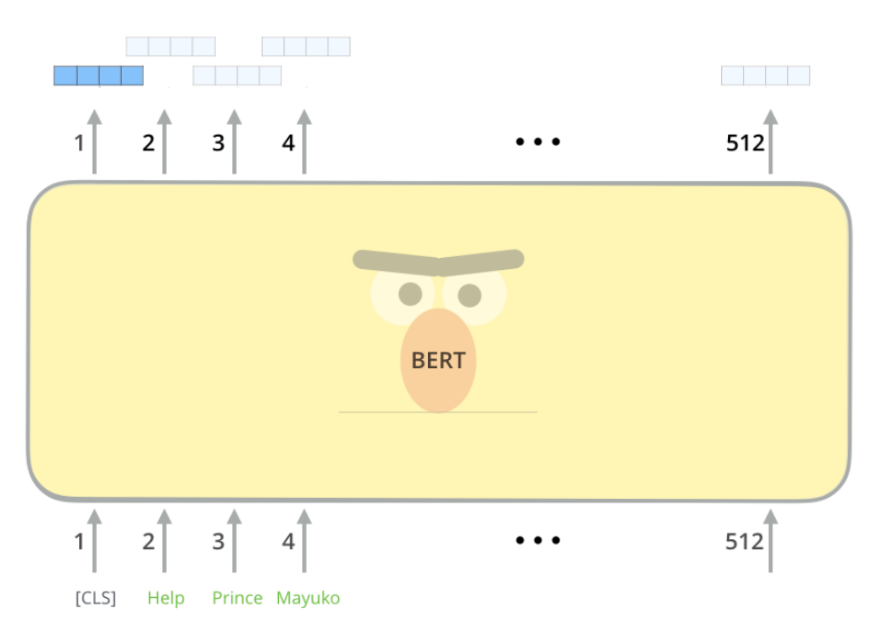

In [17]:
# lets first get a single sentence as an example
sent_position = 7
sent = df.loc[sent_position, "sentences"]
print(sent + "\n")

# tokenize
sent_encoded = tokenizer(sent,  max_length=60, padding="max_length", truncation=True, return_tensors='pt')
sent_encoded["input_ids"]

JPMorgan Chase has experienced an extended period of significant change in laws and regulations affecting the financial services industry, both within and outside the U.S.



tensor([[  101, 16545,  5302, 16998,  5252,  2038,  5281,  2019,  3668,  2558,
          1997,  3278,  2689,  1999,  4277,  1998,  7040, 12473,  1996,  3361,
          2578,  3068,  1010,  2119,  2306,  1998,  2648,  1996,  1057,  1012,
          1055,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])

In [18]:
# apply forward pass through the model (do not accumulate gradients; we are not training)
with torch.no_grad():
    result = model(**sent_encoded)

In [19]:
# what is "result" ?
type(result)

transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions

In [ ]:
#@title
HTML("""
<div class="alert">
  <h2> Exercise </h2>
  <br>
  <p> 1. Exploring the Model Hub</p>
  <br>
  <ol type="a">
  <li> What is the most popular model for the "text classifiation" task that supports the Spanish language? </li>
  <li> I'm interested in a language model called RoBERTa. Search for any version of the model in HuggingFace and load it in Python using the "AutoModel()" class.  </li>
  </ol>
  <br>
  <p> 2. Exploring the "result" object</p>
  <br>
  <p> Go to HuggingFace's documentation for the <a href="https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions"> BaseModelOutputWithPoolingAndCrossAttention</a>
  </p>
  <ol type="a">
  <li> Get the shape of the "last_hidden_state" of the model (i.e. the final layer of the model). What is the meaning of each value? </li>
  <li> Get the embedded representation of the [CLS] token from the last_hidden_state </li>
  <li> Get the 5th hidden layer of the model </li>
  </ol>

</div>

<style>
.alert {
  padding: 20px;
  background-color: #586BA4;
  color: white;
  margin-bottom: 15px;
}

h2{
  font-size: 30px;
  color: white;
}

li, p{
  font-size: 20px;
}

</style>
""")

### Creating a sequence representation

There are several ways in which the output of BERT can be used to generate an embedded representation of a sequence of text. We will show some of them below. However, following the way in which BERT was pre-trained, we will focus on the embedded representation of the ```[CLS]``` token in the last hidden layer. This representation, is the one used to fullfil the next sentence prediction task on which BERT is trained.

In [24]:
# use the embedding of the [CLS] token as the representation of the sequence
cls_emb = result.hidden_states[-1][0][0]
print(f"Shape of [CLS] embedding: {cls_emb.shape}")

Shape of [CLS] embedding: torch.Size([768])


In [25]:
# we can also average the embeddings of all tokens in a given hidden state (e.g. layer 6)
avg_emb = torch.mean(result.hidden_states[5][0], dim=0)
print(f"Shape of average embedding: {avg_emb.shape}")

Shape of average embedding: torch.Size([768])


# 3. Domain-specific models

So far, we have used the base version of BERT to generate features. However, one concern with this approach is that the language in the training data used for base BERT (i.e. Wikipedia and Books) migth be very different from the language in 10-K reports. In order to alleviate this concern, we will use a different version of the model trained on 260,773 10-K filings from 1993-2019.

These family of models are called [SEC-BERT](https://huggingface.co/nlpaueb/sec-bert-base) and were developed by the Natural Language Processing Group at the Athens University of Economics and Business.

> Remember that you can use [HuggingFace's ModelHub](https://huggingface.co/models) to explore more models trained on different corpora.

In [26]:
# load a tokenizer using the name of the model we want to use
sec_tokenizer = AutoTokenizer.from_pretrained("nlpaueb/sec-bert-base")

# inspect the configuration of the tokenizer
sec_tokenizer

BertTokenizerFast(name_or_path='nlpaueb/sec-bert-base', vocab_size=30000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [23]:
# load the model trained on 10-K report using its name
sec_model = AutoModel.from_pretrained("nlpaueb/sec-bert-base")

# 4. Finetuning a model

We will show how we can finetune a BERT model for any classification task we want. Finetuning involves training (with a very small learning rate) all of the parameters of the model for a particular task. This is one of the most powerful ways of using modern language models.

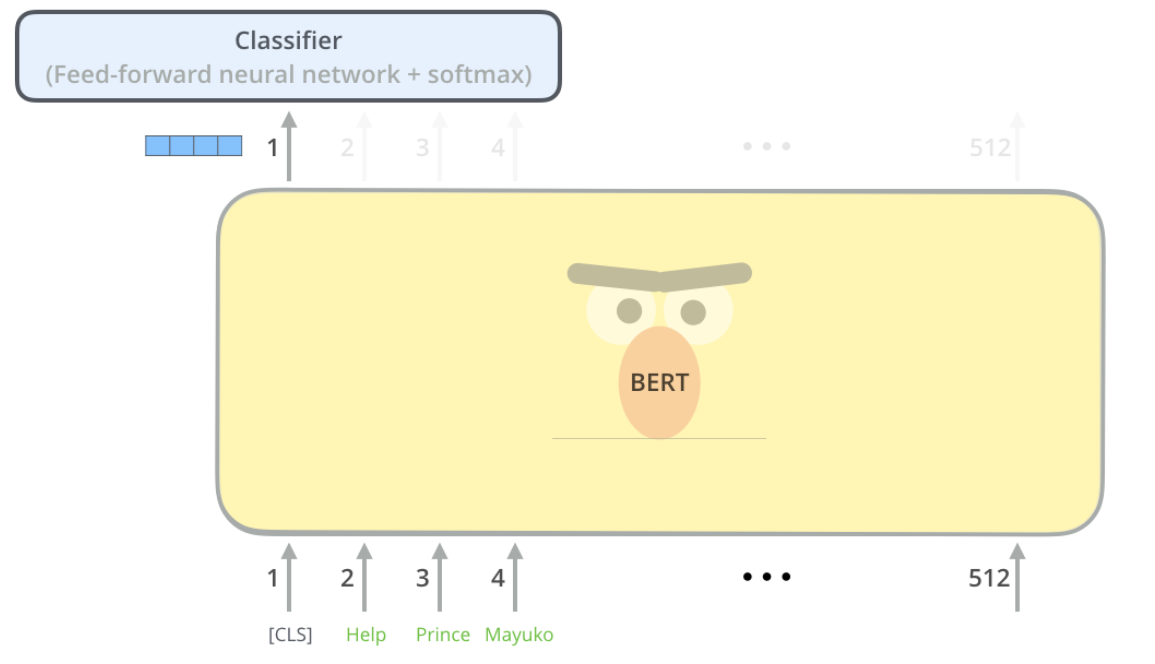

*Source: Alammar (2018)*

In [27]:
# get only the NAICS2 code for each sentence to use as the labels for our regression
labels = df[["naics2"]]

In [28]:
# create list with all the indexes of available sentences
sent_idxs = list(range(0, len(labels)))
len(sent_idxs)

6798

In [29]:
# perform a train/test split
train_idxs, test_idxs = train_test_split(sent_idxs, test_size=0.2, random_state=92)
print(f" Train sentences: {len(train_idxs)}\n", f"Test sentences: {len(test_idxs)}")

 Train sentences: 5438
 Test sentences: 1360


In [30]:
# format the train data adequately
df_finetune = df.loc[train_idxs].copy()

df_finetune = df_finetune[["sentences", "naics2"]]
df_finetune.columns = ["sentences", "label"]

# transform labels into integers
df_finetune["label"] = df_finetune["label"].astype(int)
df_finetune

# map labels from original sector code to ints from 0 to num_sectors
num_sectors = len(df_finetune.groupby('label').size())
naics2id = {k:v for k,v in zip(df_finetune.groupby('label').size().index.values, range(0, num_sectors))}
id2naics = {v:k for k,v in naics2id.items()}
df_finetune["label"] = df_finetune["label"].apply(lambda x: naics2id[x])
df_finetune

,sentences,label
3639,We experienced a work stoppage in 2008 when a ...,0
2680,"Finally, holders of the Tesla Convertible Note...",0
1507,There can be significant differences between o...,3
911,We also rely on other companies to maintain re...,2
621,The techniques used for attacks by third parti...,0
...,...,...
5007,Our revenues and cash requirements are affecte...,1
710,"As is common in our industry, our advertisers ...",2
6162,Global markets for the Company's products and ...,0
4138,"Longer payment cycles in some countries, incre...",2


In [31]:
# format the test data adequately
df_test = df.loc[test_idxs].copy()

df_test = df_test[["sentences", "naics2"]]
df_test.columns = ["sentences", "label"]

# transform labels into integers
df_test["label"] = df_test["label"].astype(int)
df_test

# map labels from original sector code to ints from 0 to num_sectors
df_test["label"] = df_test["label"].apply(lambda x: naics2id[x])
df_test

,sentences,label
1236,• integration of the acquired company's accou...,2
474,Competition for qualified personnel within the...,3
3418,Any reduction in our and our subsidiaries' cre...,3
6564,Natural disasters or other catastrophes could ...,1
2646,For the battery and drive unit on our current ...,0
...,...,...
1950,Regulatory requirements in the U.S. and in non...,3
6648,If personal information of our customers or em...,2
6529,The evolution of retailing in online and mobil...,1
6452,"Our success depends, in part, on our ability t...",1


In [32]:
# transform data into Dataset class
finetune_dataset = Dataset.from_pandas(df_finetune)
test_dataset = Dataset.from_pandas(df_test)

In [33]:
# tokenize the dataset
def tokenize_function(examples):
    return sec_tokenizer(examples["sentences"], max_length=60, padding="max_length", truncation=True)

tokenized_ft = finetune_dataset.map(tokenize_function, batched=True)    # batched=True is key for training
tokenized_test = test_dataset.map(tokenize_function, batched=True)

tokenized_ft

Map:   0%|          | 0/5438 [00:00<?, ? examples/s]

Map:   0%|          | 0/1360 [00:00<?, ? examples/s]

Dataset({
    features: ['sentences', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5438
})

In [34]:
# load the model for finetunning.
# NOTE that we use a different class from the transformers library:
# AutoModel vs. AutoModelForSequenceClassification
num_labels = len(df_finetune.groupby('label').size())
model_ft = AutoModelForSequenceClassification.from_pretrained("nlpaueb/sec-bert-base",
                                                              num_labels=num_labels,
                                                              output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/sec-bert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You can find a complete description of all the available parameters of the ```TrainingArguments()``` class [here](https://huggingface.co/docs/transformers/v4.21.2/en/main_classes/trainer#transformers.TrainingArguments).

In [36]:
# define the main arguments for training
training_args = TrainingArguments("./",                               # path to save model
                                  learning_rate=5e-5,                 # we use a very small learning rate
                                  num_train_epochs=3,                 # number of iterations through the corpus
                                  per_device_train_batch_size=8,      # defined by the capacity of our GPU
                                  per_device_eval_batch_size=8,       # defined by the capacity of our GPU
                                  evaluation_strategy="no",
                                  save_strategy="no")

In [37]:
# define the set of metrics to be computed through the training process
def compute_metrics(eval_pred):
    metric1 = load_metric("precision")
    metric2 = load_metric("recall")
    metric3 = load_metric("f1")
    metric4 = load_metric("accuracy")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision = metric1.compute(predictions=predictions, references=labels, average="micro")["precision"]
    recall = metric2.compute(predictions=predictions, references=labels, average="micro")["recall"]
    f1 = metric3.compute(predictions=predictions, references=labels, average="micro")["f1"]
    accuracy = metric4.compute(predictions=predictions, references=labels)["accuracy"]

    return {"precision": precision, "recall": recall,
            "f1": f1, "accuracy": accuracy}

# by default the Trainer will use MSEloss from (torch.nn) for regression and
# CrossEntropy loss for classification
trainer = Trainer(
    model=model_ft,
    args=training_args,
    train_dataset=tokenized_ft,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

In [38]:
# train model (should take around 4 minutes with GPU)
trainer.train()

Step,Training Loss
500,0.845900
1000,0.550200
1500,0.387500
2000,0.228900


TrainOutput(global_step=2040, training_loss=0.49546419311972223, metrics={'train_runtime': 250.8154, 'train_samples_per_second': 65.044, 'train_steps_per_second': 8.133, 'total_flos': 503023926150720.0, 'train_loss': 0.49546419311972223, 'epoch': 3.0})

In [39]:
# save final version of the model
trainer.save_model("./ft_model/")

In [40]:
# evaluate final model on the test dataset
results = trainer.predict(tokenized_test)
final_metrics = results[2]
print(final_metrics)

<ipython-input-37-ffdf1da1db83>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric1 = load_metric("precision")


{'test_loss': 1.0022221803665161, 'test_precision': 0.774264705882353, 'test_recall': 0.774264705882353, 'test_f1': 0.774264705882353, 'test_accuracy': 0.774264705882353, 'test_runtime': 12.467, 'test_samples_per_second': 109.088, 'test_steps_per_second': 13.636}


In [41]:
# compare finetuning to other methods
df_compare = pd.DataFrame({"accuracy": [0.616176, 0.627206, 0.708088, final_metrics["test_accuracy"]],
                           "model": ["word_embeddings", "BERT", "SEC BERT", "Finetuned BERT"]})
df_compare

,accuracy,model
0,0.616176,word_embeddings
1,0.627206,BERT
2,0.708088,SEC BERT
3,0.774265,Finetuned BERT


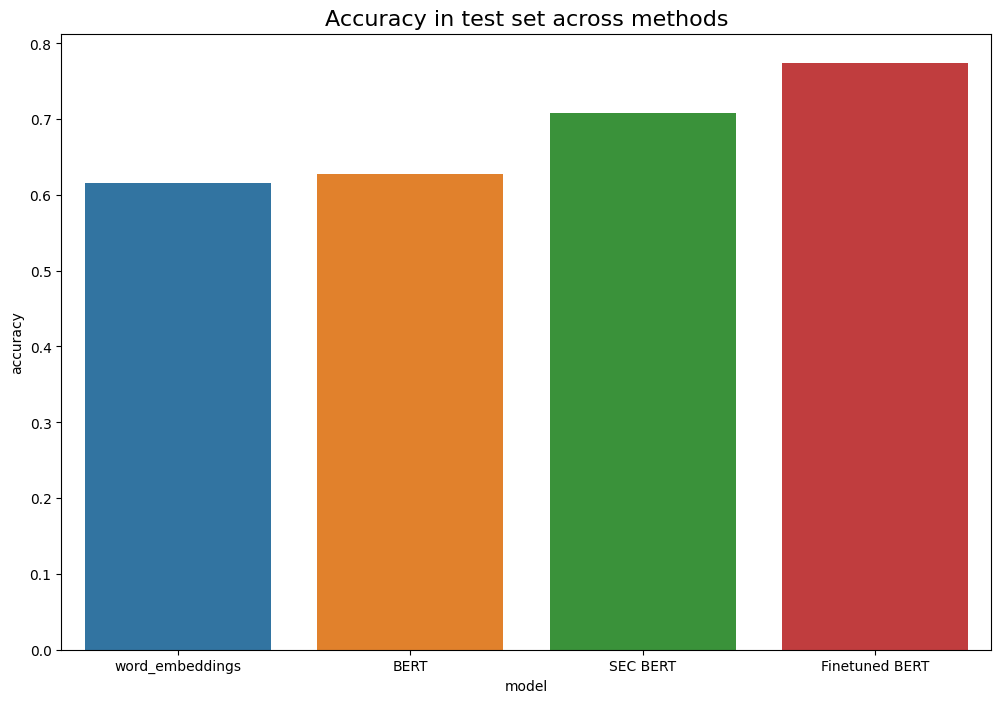

In [42]:
plt.figure(figsize=(12,8))
sns.barplot(data=df_compare, x="model", y="accuracy")
plt.title("Accuracy in test set across methods", fontsize=16)
plt.show()

# 5. Usages of finetuned model

In [43]:
# load finetuned model
final_model = BertForSequenceClassification.from_pretrained("./ft_model/",
                                                            output_hidden_states=False,
                                                            output_attentions=False)

final_model.eval()
print("Model ready")

Model ready


In [44]:
# use a text classification pipeline
classifier = TextClassificationPipeline(model=final_model,
                                        tokenizer=sec_tokenizer,
                                        device="cuda",
                                        return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


## Sectorial membership probability

In [45]:
# get firms identifier
firms = df["cik"].unique()
firms

array([  19617,   70858,   37996, 1418091,  927628,   83246, 1318605,
         18230,    4962,   12927, 1467858, 1652044,  104169,  769397,
         27419,  794367, 1634117, 1341439, 1754301,  320193,  909832,
       1744489])

In [46]:
# get an average of the probability for each sector across all sentences of a firm
# (takes around 2 minutes)

firms_composition = {}
for firm in firms:

    print(f"Processing firm: {firm}")
    # calculate probabilities for all the text of each firm
    df_firm = df.loc[df["cik"] == firm]
    all_probs = []
    for text in df_firm["sentences"].values:
        probs = classifier(text)[0]
        all_probs.append(probs)

    # sum all the probabilities for the same label
    results_firm = {k:0 for k in range(4)}
    for p in all_probs:
        for label in range(4):
            results_firm[label] += p[label]["score"]

    results_firm = {k:v/len(all_probs) for k,v in results_firm.items()}
    firms_composition[firm] = results_firm

Processing firm: 19617


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Processing firm: 70858
Processing firm: 37996
Processing firm: 1418091
Processing firm: 927628
Processing firm: 83246
Processing firm: 1318605
Processing firm: 18230
Processing firm: 4962
Processing firm: 12927
Processing firm: 1467858
Processing firm: 1652044
Processing firm: 104169
Processing firm: 769397
Processing firm: 27419
Processing firm: 794367
Processing firm: 1634117
Processing firm: 1341439
Processing firm: 1754301
Processing firm: 320193
Processing firm: 909832
Processing firm: 1744489


In [50]:
# read firms metadata
file_id = "1vFcFJYdLD0sE_fbhGES8KQmvMcLuuCdc"
df_cov = pd.read_csv(f"https://drive.google.com/uc?export=download&id={file_id}&authuser=0&export=download")
df_cov = df_cov.loc[df_cov["cik"].isin(firms)]
df_cov.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,conm,curcd,act,at,emp,cik,costat,naics,naics2,naics2_name
26,1447,20191231,2019,FS,C,D,STD,AXP,AMERICAN EXPRESS CO,USD,NaN,198321.0,64.5,4962,A,522210,52,Finance and Insurance
27,1447,20191231,2019,INDL,C,D,STD,AXP,AMERICAN EXPRESS CO,USD,NaN,198321.0,64.5,4962,A,522210,52,Finance and Insurance
41,1690,20190930,2019,INDL,C,D,STD,AAPL,APPLE INC,USD,162819.0,338516.0,137.0,320193,A,334220,33,Manufacturing
51,1878,20200131,2019,INDL,C,D,STD,ADSK,AUTODESK INC,USD,2659.3,6179.3,10.1,769397,A,519130,51,Information
70,2285,20191231,2019,INDL,C,D,STD,BA,BOEING CO,USD,102229.0,133625.0,161.1,12927,A,336411,33,Manufacturing


In [51]:
# create a dataframe
df_firms = pd.DataFrame()
df_firms["cik"] = firms_composition.keys()
df_firms["name"] = [df_cov.loc[df_cov["cik"] == cik, "conm"].iloc[0] for cik in firms]
df_firms["naics2_name"] = [df.loc[df["cik"] == cik, "naics2_name"].iloc[0] for cik in firms]

# add text-based data
df_firms["manufacturing"] = [comp[0] for comp in firms_composition.values()]
df_firms["retail_trade"] = [comp[1] for comp in firms_composition.values()]
df_firms["information"] = [comp[2] for comp in firms_composition.values()]
df_firms["finance"] = [comp[3] for comp in firms_composition.values()]

In [52]:
# explore!
df_firms

,cik,name,naics2_name,manufacturing,retail_trade,information,finance
0,19617,JPMORGAN CHASE & CO,Finance and Insurance,0.000263,0.000427,0.025304,0.974006
1,70858,BANK OF AMERICA CORP,Finance and Insurance,0.007967,0.005808,0.006117,0.980107
2,37996,FORD MOTOR CO,Manufacturing,0.968863,0.001919,0.021727,0.007491
3,1418091,TWITTER INC,Information,0.016894,0.021304,0.953983,0.007818
4,927628,CAPITAL ONE FINANCIAL CORP,Finance and Insurance,0.007890,0.012804,0.035794,0.943511
5,83246,HSBC USA INC,Finance and Insurance,0.013475,0.013245,0.015880,0.957400
6,1318605,TESLA INC,Manufacturing,0.910769,0.017106,0.062238,0.009886
7,18230,CATERPILLAR INC,Manufacturing,0.872665,0.023519,0.077675,0.026141
8,4962,AMERICAN EXPRESS CO,Finance and Insurance,0.017470,0.034208,0.034661,0.913661
9,12927,BOEING CO,Manufacturing,0.947450,0.011733,0.027489,0.013328


## Out-of-sample text

We can now use our finetuned model to predict the sector of any given sequence of text.

In [53]:
# define a target sentence
outside_target = "We are worried about misinformation and fake news."

In [54]:
# get predicted probabilities for each label
probs = classifier(outside_target)[0]
probs

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


[{'label': 'LABEL_0', 'score': 0.0007657787064090371},
 {'label': 'LABEL_1', 'score': 0.016249358654022217},
 {'label': 'LABEL_2', 'score': 0.9823951125144958},
 {'label': 'LABEL_3', 'score': 0.0005897361552342772}]

In [55]:
# clean the labels
for pred_dict in probs:

    # extract the ID from the label
    id = int(pred_dict["label"].split("_")[1])
    # convert to NAICS code
    naics = id2naics[id]
    naics_name = df.loc[df["naics2"] == naics, "naics2_name"].iloc[0]
    print(f"Probability for NAICS sector {naics_name} (code {naics}): {pred_dict['score']}")

Probability for NAICS sector Manufacturing (code 33): 0.0007657787064090371
Probability for NAICS sector Retail Trade (code 45): 0.016249358654022217
Probability for NAICS sector Information (code 51): 0.9823951125144958
Probability for NAICS sector Finance and Insurance (code 52): 0.0005897361552342772


In [56]:
# wrap process in a function
def print_predictions(text):
    # get predicted probabilities for each label
    probs = classifier(text)[0]

    # clean the labels
    for pred_dict in probs:

        # extract the ID from the label
        id = int(pred_dict["label"].split("_")[1])
        # convert to NAICS code
        naics = id2naics[id]
        naics_name = df.loc[df["naics2"] == naics, "naics2_name"].iloc[0]
        print(f"Probability for NAICS sector {naics_name} (code {naics}): {pred_dict['score']}")

In [57]:
print_predictions("Our production of cars is affected by the price of steel.")

Probability for NAICS sector Manufacturing (code 33): 0.9991006851196289
Probability for NAICS sector Retail Trade (code 45): 0.00021794700296595693
Probability for NAICS sector Information (code 51): 0.00024364044656977057
Probability for NAICS sector Finance and Insurance (code 52): 0.0004376812430564314


In [59]:
print_predictions("The decisions from the federal reserve board can affect us greatly.")

Probability for NAICS sector Manufacturing (code 33): 0.0002537828986532986
Probability for NAICS sector Retail Trade (code 45): 0.0002422634424874559
Probability for NAICS sector Information (code 51): 0.00023477709328290075
Probability for NAICS sector Finance and Insurance (code 52): 0.9992691874504089


In [63]:
print_predictions("We face multiple types of risks")

Probability for NAICS sector Manufacturing (code 33): 0.021238751709461212
Probability for NAICS sector Retail Trade (code 45): 0.6477867364883423
Probability for NAICS sector Information (code 51): 0.224751815199852
Probability for NAICS sector Finance and Insurance (code 52): 0.10622266680002213
